In [220]:
#importing required libraries

from sklearn.datasets import fetch_20newsgroups

import numpy as np
import pandas as pd

import re
import string

import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.stem import SnowballStemmer

from collections import Counter 
from gensim.models import Word2Vec

from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data input

In [222]:
# store the dataset

newsgroups_train_data = fetch_20newsgroups(subset='all', shuffle=True, remove = ('headers', 'footers', 'quotes'))

In [223]:
# check for data information

newsgroups_train_data.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [224]:
# to check for the dataset documents and categories

print(f'{len(newsgroups_train_data.data)} documents')
print(f'{len(newsgroups_train_data.target_names)} categories')

18846 documents
20 categories


### Data preprocessing

In [328]:
# store into DataFrame

df = pd.DataFrame()
df['text'] = newsgroups_train_data.data
df['label'] = newsgroups_train_data.target
df.head()

,text,label
0,\n\nI am sure some bashers of Pens fans are pr...,10
1,My brother is in the market for a high-perform...,3
2,\n\n\n\n\tFinally you said what you dream abou...,17
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3
4,1) I have an old Jasmine drive which I cann...,4


In [329]:
df.shape

(18846, 2)

In [330]:
# add label name / source name to the df

label_name = []

for i in df['label']:
  label_name.append(newsgroups_train_data.target_names[i])

df['label_name'] = label_name

df.head()

,text,label,label_name
0,\n\nI am sure some bashers of Pens fans are pr...,10,rec.sport.hockey
1,My brother is in the market for a high-perform...,3,comp.sys.ibm.pc.hardware
2,\n\n\n\n\tFinally you said what you dream abou...,17,talk.politics.mideast
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,comp.sys.ibm.pc.hardware
4,1) I have an old Jasmine drive which I cann...,4,comp.sys.mac.hardware


In [331]:
# add initial text's lengths to the df

df['word_num_1'] = df['text'].apply(lambda x: len(str(x).split()))
df.head()

,text,label,label_name,word_num_1
0,\n\nI am sure some bashers of Pens fans are pr...,10,rec.sport.hockey,137
1,My brother is in the market for a high-perform...,3,comp.sys.ibm.pc.hardware,53
2,\n\n\n\n\tFinally you said what you dream abou...,17,talk.politics.mideast,241
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,comp.sys.ibm.pc.hardware,144
4,1) I have an old Jasmine drive which I cann...,4,comp.sys.mac.hardware,125


In [332]:
# check for empty 'text' columns

text_empty = df['text'].str.len() < 1

print("Empty text indexes to be deleted :", df.loc[text_empty].index)
df.drop(df.loc[text_empty].index, inplace=True)

df.head()

Empty text indexes to be deleted : Int64Index([   91,   104,   127,   135,   161,   185,   192,   219,   297,
              318,
            ...
            18165, 18175, 18177, 18203, 18278, 18324, 18346, 18445, 18652,
            18789],
           dtype='int64', length=380)


,text,label,label_name,word_num_1
0,\n\nI am sure some bashers of Pens fans are pr...,10,rec.sport.hockey,137
1,My brother is in the market for a high-perform...,3,comp.sys.ibm.pc.hardware,53
2,\n\n\n\n\tFinally you said what you dream abou...,17,talk.politics.mideast,241
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,comp.sys.ibm.pc.hardware,144
4,1) I have an old Jasmine drive which I cann...,4,comp.sys.mac.hardware,125


In [333]:
df.shape

(18466, 4)

In [335]:
# find duplicate rows

duplicate_text = df[df.duplicated('text')]
  
# Print the duplicate part of the Dataframe
print("Duplicate Rows based on text :\n", duplicate_text)

# drop the rows having duplicate texts
df.drop(duplicate_text.index, inplace=True)

df

Duplicate Rows based on text :
 Empty DataFrame
Columns: [text, label, label_name, word_num_1]
Index: []


,text,label,label_name,word_num_1
0,\n\nI am sure some bashers of Pens fans are pr...,10,rec.sport.hockey,137
1,My brother is in the market for a high-perform...,3,comp.sys.ibm.pc.hardware,53
2,\n\n\n\n\tFinally you said what you dream abou...,17,talk.politics.mideast,241
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,comp.sys.ibm.pc.hardware,144
4,1) I have an old Jasmine drive which I cann...,4,comp.sys.mac.hardware,125
...,...,...,...,...
18841,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...,13,sci.med,300
18842,\nNot in isolated ground recepticles (usually ...,12,sci.electronics,28
18843,I just installed a DX2-66 CPU in a clone mothe...,3,comp.sys.ibm.pc.hardware,113
18844,\nWouldn't this require a hyper-sphere. In 3-...,1,comp.graphics,56


In [338]:
# initial word statistics

df['word_num_1'].describe()

count    18286.000000
mean       186.589413
std        507.396357
min          0.000000
25%         43.000000
50%         86.000000
75%        170.000000
max      11765.000000
Name: word_num_1, dtype: float64

In [339]:
# check for longest text

df[df['word_num_1']==11765]

,text,label,label_name,word_num_1
17014,Since electrical wiring questions do turn up f...,12,sci.electronics,11765


In [340]:
# find text with no words and delete the rows

min_text = df[df['word_num_1']==0]

df.drop(min_text.index, inplace=True)

df

,text,label,label_name,word_num_1
0,\n\nI am sure some bashers of Pens fans are pr...,10,rec.sport.hockey,137
1,My brother is in the market for a high-perform...,3,comp.sys.ibm.pc.hardware,53
2,\n\n\n\n\tFinally you said what you dream abou...,17,talk.politics.mideast,241
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,comp.sys.ibm.pc.hardware,144
4,1) I have an old Jasmine drive which I cann...,4,comp.sys.mac.hardware,125
...,...,...,...,...
18841,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...,13,sci.med,300
18842,\nNot in isolated ground recepticles (usually ...,12,sci.electronics,28
18843,I just installed a DX2-66 CPU in a clone mothe...,3,comp.sys.ibm.pc.hardware,113
18844,\nWouldn't this require a hyper-sphere. In 3-...,1,comp.graphics,56


In [342]:
# resultant shape

df.shape

(18271, 4)

The data set contains 18,846 non-null newsgroup posts out of 20 different categories. 380+15 of them are empty and 180 are duplicated posts. The resulting data set thus contains 18,271 entries.

In [343]:
# exploring no. of unique labels

df['label'].nunique()

20

In [344]:
# find label counts

df['label'].value_counts()

15    975
10    975
8     967
5     965
11    962
3     961
9     957
13    957
12    954
14    952
1     951
2     944
6     943
7     936
4     928
17    918
16    886
0     779
18    756
19    605
Name: label, dtype: int64

In [345]:
# overall total texts or labels
df['label'].value_counts().sum()

18271

In [346]:
# count per label
df['label_name'].value_counts()

rec.sport.hockey            975
soc.religion.christian      975
rec.motorcycles             967
comp.windows.x              965
sci.crypt                   962
comp.sys.ibm.pc.hardware    961
sci.med                     957
rec.sport.baseball          957
sci.electronics             954
sci.space                   952
comp.graphics               951
comp.os.ms-windows.misc     944
misc.forsale                943
rec.autos                   936
comp.sys.mac.hardware       928
talk.politics.mideast       918
talk.politics.guns          886
alt.atheism                 779
talk.politics.misc          756
talk.religion.misc          605
Name: label_name, dtype: int64

*The dataset is almost a balanced dataset.*

In [347]:
# regroup the documents into 6 broad categories:
    ## recreation
    ## science
    ## computer
    ## politics
    ## religion
    ## misc_sales
    

# replace to recreation
df['label_name'].replace({'rec.sport.hockey':'recreation', 'rec.motorcycles':'recreation', 'rec.sport.baseball':'recreation', 'rec.autos':'recreation'}, inplace=True) 

# replace to science
df['label_name'].replace({'sci.crypt':'science', 'sci.med':'science', 'sci.electronics':'science', 'sci.space':'science'}, inplace=True) 

# replace to computer
df['label_name'].replace({'comp.windows.x':'computer', 'comp.sys.ibm.pc.hardware':'computer', 'comp.graphics':'computer', 'comp.os.ms-windows.misc':'computer', 'comp.sys.mac.hardware':'computer'}, inplace=True) 

# replace to politics
df['label_name'].replace({'talk.politics.mideast':'politics', 'talk.politics.guns':'politics', 'talk.politics.misc':'politics'}, inplace=True) 

# replace to religion
df['label_name'].replace({'soc.religion.christian': 'religion', 'alt.atheism':'religion', 'talk.religion.misc' :'religion'}, inplace=True) 

# replace to misc_sales
df['label_name'].replace({'misc.forsale':'misc_sales'}, inplace=True) 


# label encoding the Label_name according to the new grouping
from sklearn.preprocessing import LabelEncoder
  
le = LabelEncoder()
df['label']= le.fit_transform(df['label_name'])
df


,text,label,label_name,word_num_1
0,\n\nI am sure some bashers of Pens fans are pr...,3,recreation,137
1,My brother is in the market for a high-perform...,0,computer,53
2,\n\n\n\n\tFinally you said what you dream abou...,2,politics,241
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,0,computer,144
4,1) I have an old Jasmine drive which I cann...,0,computer,125
...,...,...,...,...
18841,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...,5,science,300
18842,\nNot in isolated ground recepticles (usually ...,5,science,28
18843,I just installed a DX2-66 CPU in a clone mothe...,0,computer,113
18844,\nWouldn't this require a hyper-sphere. In 3-...,0,computer,56


In [348]:
## text preprocessing
  # lowercase
  # remove urls
  # remove multiple spaces
  # Replace dash between words
  # remove punctutaions

def clean_text_func(text):   

    text = text.lower()
    text = text.strip()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub(r"\d+", " ", text)  
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)
    text = re.sub(f'[{re.escape(string.punctuation)}]', '' , text)
    text = re.sub(r"\[(.*?)\]", "", text)
    text = re.sub(r"\s+", " ", text)  
    
    return text

# function call on column 'text' and add a new column to the df
df['text_cleaned_after_punct_removal'] = df['text'].apply(clean_text_func)

df.head()

,text,label,label_name,word_num_1,text_cleaned_after_punct_removal
0,\n\nI am sure some bashers of Pens fans are pr...,3,recreation,137,i am sure some bashers of pens fans are pretty...
1,My brother is in the market for a high-perform...,0,computer,53,my brother is in the market for a high perform...
2,\n\n\n\n\tFinally you said what you dream abou...,2,politics,241,finally you said what you dream about mediterr...
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,0,computer,144,think its the scsi card doing the dma transfer...
4,1) I have an old Jasmine drive which I cann...,0,computer,125,i have an old jasmine drive which i cannot us...


In [349]:
# check for a random row (say 100th)
print(df['text_cleaned_after_punct_removal'][100])

yeah right sorta like the indian sub contient eh


In [350]:
# remove stop words for each 'text' column

#assigning stop-words of englisgh language
stop_words = stopwords.words('english')
print("English language stop-wrods are: ", stop_words)

# add a new column to the df after stop-words removal
df['text_cleaned_after_stopword_removal'] = df['text_cleaned_after_punct_removal'].str.split() \
    .apply(lambda x: ' '.join([word for word in x if word not in stop_words]))

print()

df.head()

English language stop-wrods are:  ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'onl

,text,label,label_name,word_num_1,text_cleaned_after_punct_removal,text_cleaned_after_stopword_removal
0,\n\nI am sure some bashers of Pens fans are pr...,3,recreation,137,i am sure some bashers of pens fans are pretty...,sure bashers pens fans pretty confused lack ki...
1,My brother is in the market for a high-perform...,0,computer,53,my brother is in the market for a high perform...,brother market high performance video card sup...
2,\n\n\n\n\tFinally you said what you dream abou...,2,politics,241,finally you said what you dream about mediterr...,finally said dream mediterranean new area grea...
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,0,computer,144,think its the scsi card doing the dma transfer...,think scsi card dma transfers disks scsi card ...
4,1) I have an old Jasmine drive which I cann...,0,computer,125,i have an old jasmine drive which i cannot us...,old jasmine drive cannot use new system unders...


In [351]:
# now again check the 100th row after stop-word removal

print(df['text_cleaned_after_stopword_removal'][100])

yeah right sorta like indian sub contient eh


In [352]:
# tokenize the column named 'text_cleaned_after_stopword_removal'

tokenzier = nltk.tokenize.RegexpTokenizer(r'\w+')

# add a new column to the df for tokens
df['tokens'] = df['text_cleaned_after_stopword_removal'].apply(lambda x: tokenzier.tokenize(x))

df.head()

,text,label,label_name,word_num_1,text_cleaned_after_punct_removal,text_cleaned_after_stopword_removal,tokens
0,\n\nI am sure some bashers of Pens fans are pr...,3,recreation,137,i am sure some bashers of pens fans are pretty...,sure bashers pens fans pretty confused lack ki...,"[sure, bashers, pens, fans, pretty, confused, ..."
1,My brother is in the market for a high-perform...,0,computer,53,my brother is in the market for a high perform...,brother market high performance video card sup...,"[brother, market, high, performance, video, ca..."
2,\n\n\n\n\tFinally you said what you dream abou...,2,politics,241,finally you said what you dream about mediterr...,finally said dream mediterranean new area grea...,"[finally, said, dream, mediterranean, new, are..."
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,0,computer,144,think its the scsi card doing the dma transfer...,think scsi card dma transfers disks scsi card ...,"[think, scsi, card, dma, transfers, disks, scs..."
4,1) I have an old Jasmine drive which I cann...,0,computer,125,i have an old jasmine drive which i cannot us...,old jasmine drive cannot use new system unders...,"[old, jasmine, drive, cannot, use, new, system..."


In [353]:
# lemmatization of tokens

lemma = WordNetLemmatizer()

def lemmatize(text):
  return [lemma.lemmatize(word) for word in text]

# add a new column to the df after lemmatization
df['lemmatized_text'] = df['tokens'].apply(lemmatize)

df.head()

,text,label,label_name,word_num_1,text_cleaned_after_punct_removal,text_cleaned_after_stopword_removal,tokens,lemmatized_text
0,\n\nI am sure some bashers of Pens fans are pr...,3,recreation,137,i am sure some bashers of pens fans are pretty...,sure bashers pens fans pretty confused lack ki...,"[sure, bashers, pens, fans, pretty, confused, ...","[sure, bashers, pen, fan, pretty, confused, la..."
1,My brother is in the market for a high-perform...,0,computer,53,my brother is in the market for a high perform...,brother market high performance video card sup...,"[brother, market, high, performance, video, ca...","[brother, market, high, performance, video, ca..."
2,\n\n\n\n\tFinally you said what you dream abou...,2,politics,241,finally you said what you dream about mediterr...,finally said dream mediterranean new area grea...,"[finally, said, dream, mediterranean, new, are...","[finally, said, dream, mediterranean, new, are..."
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,0,computer,144,think its the scsi card doing the dma transfer...,think scsi card dma transfers disks scsi card ...,"[think, scsi, card, dma, transfers, disks, scs...","[think, scsi, card, dma, transfer, disk, scsi,..."
4,1) I have an old Jasmine drive which I cann...,0,computer,125,i have an old jasmine drive which i cannot us...,old jasmine drive cannot use new system unders...,"[old, jasmine, drive, cannot, use, new, system...","[old, jasmine, drive, cannot, use, new, system..."


In [354]:
# combine lemmatized words

def combine(lemmatize_words):
  combine = ' '.join(lemmatize_words)
  return combine

# adding a new column to the df 
df['final_text'] = df['lemmatized_text'].apply(lambda x : combine(x))

df.head()

,text,label,label_name,word_num_1,text_cleaned_after_punct_removal,text_cleaned_after_stopword_removal,tokens,lemmatized_text,final_text
0,\n\nI am sure some bashers of Pens fans are pr...,3,recreation,137,i am sure some bashers of pens fans are pretty...,sure bashers pens fans pretty confused lack ki...,"[sure, bashers, pens, fans, pretty, confused, ...","[sure, bashers, pen, fan, pretty, confused, la...",sure bashers pen fan pretty confused lack kind...
1,My brother is in the market for a high-perform...,0,computer,53,my brother is in the market for a high perform...,brother market high performance video card sup...,"[brother, market, high, performance, video, ca...","[brother, market, high, performance, video, ca...",brother market high performance video card sup...
2,\n\n\n\n\tFinally you said what you dream abou...,2,politics,241,finally you said what you dream about mediterr...,finally said dream mediterranean new area grea...,"[finally, said, dream, mediterranean, new, are...","[finally, said, dream, mediterranean, new, are...",finally said dream mediterranean new area grea...
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,0,computer,144,think its the scsi card doing the dma transfer...,think scsi card dma transfers disks scsi card ...,"[think, scsi, card, dma, transfers, disks, scs...","[think, scsi, card, dma, transfer, disk, scsi,...",think scsi card dma transfer disk scsi card dm...
4,1) I have an old Jasmine drive which I cann...,0,computer,125,i have an old jasmine drive which i cannot us...,old jasmine drive cannot use new system unders...,"[old, jasmine, drive, cannot, use, new, system...","[old, jasmine, drive, cannot, use, new, system...",old jasmine drive cannot use new system unders...


In [355]:
# no. of words in final_text and add it as a column to the df

df['word_num_2'] = df['final_text'].apply(lambda x : len(str(x).split()))

df.head()

,text,label,label_name,word_num_1,text_cleaned_after_punct_removal,text_cleaned_after_stopword_removal,tokens,lemmatized_text,final_text,word_num_2
0,\n\nI am sure some bashers of Pens fans are pr...,3,recreation,137,i am sure some bashers of pens fans are pretty...,sure bashers pens fans pretty confused lack ki...,"[sure, bashers, pens, fans, pretty, confused, ...","[sure, bashers, pen, fan, pretty, confused, la...",sure bashers pen fan pretty confused lack kind...,71
1,My brother is in the market for a high-perform...,0,computer,53,my brother is in the market for a high perform...,brother market high performance video card sup...,"[brother, market, high, performance, video, ca...","[brother, market, high, performance, video, ca...",brother market high performance video card sup...,34
2,\n\n\n\n\tFinally you said what you dream abou...,2,politics,241,finally you said what you dream about mediterr...,finally said dream mediterranean new area grea...,"[finally, said, dream, mediterranean, new, are...","[finally, said, dream, mediterranean, new, are...",finally said dream mediterranean new area grea...,120
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,0,computer,144,think its the scsi card doing the dma transfer...,think scsi card dma transfers disks scsi card ...,"[think, scsi, card, dma, transfers, disks, scs...","[think, scsi, card, dma, transfer, disk, scsi,...",think scsi card dma transfer disk scsi card dm...,71
4,1) I have an old Jasmine drive which I cann...,0,computer,125,i have an old jasmine drive which i cannot us...,old jasmine drive cannot use new system unders...,"[old, jasmine, drive, cannot, use, new, system...","[old, jasmine, drive, cannot, use, new, system...",old jasmine drive cannot use new system unders...,56


In [356]:
df.shape

(18271, 10)

In [358]:
# check for final_text length statistics

df['word_num_2'].describe()

count    18271.000000
mean       103.320836
std        338.927371
min          0.000000
25%         23.000000
50%         45.000000
75%         88.000000
max      16673.000000
Name: word_num_2, dtype: float64

In [359]:
# as min=0 (shown above), therefore, let's get rid of such rows

df.drop(df[df['word_num_2']==0].index, inplace=True)

df.shape

(18244, 10)

In [360]:
# explore documents and it's vocabulary

''' list of sentences '''
docs = df["final_text"].values
print(docs)

print()
print()

''' list of list of tokenized sentences '''
tokenized_docs = df["lemmatized_text"].values
print(tokenized_docs) 



# object for vocabulary counter
vocab_count = Counter()

for token in tokenized_docs:
    vocab_count.update(token)

print("\n\nTop 10 vocalbulary counts are : \n", vocab_count.most_common(50))

['sure bashers pen fan pretty confused lack kind post recent pen massacre devil actually bit puzzled bit relieved however going put end non pittsburghers relief bit praise pen man killing devil worse thought jagr showed much better regular season stats also lot fo fun watch playoff bowman let jagr lot fun next couple game since pen going beat pulp jersey anyway disappointed see islander lose final regular season game pen rule'
 'brother market high performance video card support vesa local bus mb ram anyone suggestionsideas diamond stealth pro local bus orchid farenheit ati graphic ultra pro high performance vlb card please post email thank matt'
 'finally said dream mediterranean new area greater year like holocaust number ist july usa sweden april still cold changed calendar nothing mentioned true let say true shall azeri woman child going pay price raped killed tortured armenian hearded something called geneva convention facist ohhh forgot armenian fight nobody forgot killing raping

### Generate vector representations for news documents.

In [487]:
# vectors from list of documents (list_of_docs) using a Word Embedding model (WEmodel)

def vectorizer(list_of_docs, WEmodel):

    feature_vec = []   # list of document vectors

    for tokens in list_of_docs:
        zero_vec = np.zeros(WEmodel.vector_size)

        vec = []

        for t in tokens:
            if t in WEmodel.wv:
                try:
                    vec.append(WEmodel.wv[t])
                except KeyError:
                    continue
        if vec:
            vec = np.asarray(vec)
            avg_vec = vec.mean(axis=0) # averaging all word vectors (assumption)
            feature_vec.append(avg_vec)
        else:
            feature_vec.append(zero_vec)

    return feature_vec

In [517]:
# call the function for the pre-processed text
model_word2vec = Word2Vec(sentences=tokenized_docs, size=100, min_count=1, seed=42)  #CBOW

vectorized_docs = vectorizer(tokenized_docs, WEmodel=model_word2vec)

### Analysis of vectors generated





In [518]:
# Word2Vec are models for generating word embedding
# here we used continuous Bag of words

In [519]:
len(vectorized_docs)

18244

In [520]:
# mapping words to vectors of real numbers
vectorized_docs   

[array([ 0.57165736, -0.10408352,  0.3490861 ,  0.23011051, -0.846071  ,
        -0.34988093, -0.04389482, -0.3369794 , -0.01832055,  0.22555767,
         0.4110949 , -0.57877916,  0.34816003,  0.03725391, -0.6344262 ,
        -0.5886372 , -0.5728592 ,  0.09747084, -0.4105791 , -0.06577361,
        -0.604919  , -0.4471401 , -0.30901793, -0.24147466, -0.2692203 ,
         0.3469292 ,  0.18891118,  0.05267963,  0.21530601, -0.2132757 ,
        -0.38758445, -0.36501536,  0.06952029, -1.0798401 , -1.0159824 ,
         1.0267689 ,  0.41889307, -0.20770718,  0.7238894 ,  0.27779695,
        -0.20038189, -0.25380346, -0.32366058,  0.8899355 , -0.22639573,
        -1.1626974 ,  0.06719168, -0.05687872,  0.29542902,  0.8532946 ,
        -0.11990526,  1.1719648 , -0.30252653, -0.25117975,  0.5670796 ,
        -0.469544  ,  0.29641038, -1.2753878 ,  0.61009115, -0.12493299,
         0.49775353,  0.47564605,  0.6642332 , -0.7080036 ,  0.19720505,
         0.6505503 ,  0.0213903 ,  0.18318586,  0.2

In [521]:
# checking for cosine similarities of 'computer'
model_word2vec.wv.most_similar("computer")

[('network', 0.8985835909843445),
 ('software', 0.8858897089958191),
 ('lab', 0.8817980289459229),
 ('supplier', 0.8667404651641846),
 ('shreve', 0.8659382462501526),
 ('product', 0.8652745485305786),
 ('vertigo', 0.8588943481445312),
 ('transmits', 0.8578941822052002),
 ('engineer', 0.8532518744468689),
 ('tech', 0.8528995513916016)]

In [522]:
# checking for cosine similarities of 'religion'
model_word2vec.wv.most_similar("religion")

[('tradition', 0.9622058868408203),
 ('religious', 0.9615211486816406),
 ('christian', 0.9613274335861206),
 ('christianity', 0.9611319303512573),
 ('islam', 0.9591835737228394),
 ('homosexuality', 0.9570591449737549),
 ('fanaticism', 0.95427405834198),
 ('contrary', 0.9536973237991333),
 ('unnatural', 0.9489696621894836),
 ('teaching', 0.9487172365188599)]

In [523]:
# checking for cosine similarities of 'game'
model_word2vec.wv.most_similar("game")

[('season', 0.9329745769500732),
 ('team', 0.927932620048523),
 ('player', 0.926209568977356),
 ('score', 0.9246396422386169),
 ('baseball', 0.9118537902832031),
 ('playoff', 0.9028993248939514),
 ('nhl', 0.8986301422119141),
 ('winning', 0.8898481726646423),
 ('espn', 0.8824771642684937),
 ('playing', 0.8776955604553223)]

In [524]:
# checking for cosine similarities of 'america'
model_word2vec.wv.most_similar("america")

[('european', 0.9481040835380554),
 ('europe', 0.942221462726593),
 ('worker', 0.9331604242324829),
 ('city', 0.927163302898407),
 ('russia', 0.9236545562744141),
 ('election', 0.9200531244277954),
 ('bullock', 0.9106413722038269),
 ('american', 0.9105077385902405),
 ('reform', 0.9104723930358887),
 ('britain', 0.9052375555038452)]

In [462]:
# train clustering model and analyze the clusters generated

#### mini batch Kmeans clsutering
  # features_mat: Matrix of features
  # k: no. of clusters
  # mb: size of batch
  # print_silhouette_values: Print silhouette values for each cluster

def mbkmeans(features_mat, k, mb=200, print_silhouette_values=False):

    # kmeans object
    km = MiniBatchKMeans(n_clusters=k, batch_size=mb).fit(features_mat)

    # for all clusters
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(features_mat, km.labels_):0.3f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(features_mat, km.labels_)
        print(f"Silhouette values:")

        silhouette_values = []

        # loop for individual cluster
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append( (i, cluster_silhouette_values.shape[0], cluster_silhouette_values.mean(), cluster_silhouette_values.min(), cluster_silhouette_values.max()) )
      
        silhouette_values = sorted( silhouette_values, key=lambda tup: tup[2], reverse=True )

        for s in silhouette_values:
            print( f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.4f} | Min:{s[3]:.4f} | Max: {s[4]:.4f}" )

    return km, km.labels_


In [463]:
# function call to analyze the clusters generated
clustering, cluster_labels = mbkmeans(features_mat=vectorized_docs, k=6, print_silhouette_values=True)

For n_clusters = 6
Silhouette coefficient: 0.115
Inertia:62649.55236500559
Silhouette values:
    Cluster 1: Size:4619 | Avg:0.1655 | Min:-0.0526 | Max: 0.3678
    Cluster 5: Size:3456 | Avg:0.1529 | Min:-0.0035 | Max: 0.3546
    Cluster 0: Size:1398 | Avg:0.1172 | Min:-0.0597 | Max: 0.3143
    Cluster 3: Size:3793 | Avg:0.1133 | Min:-0.0410 | Max: 0.3187
    Cluster 2: Size:2913 | Avg:0.0644 | Min:-0.1292 | Max: 0.3216
    Cluster 4: Size:2065 | Avg:0.0074 | Min:-0.1682 | Max: 0.2270


In [464]:
df_clusters = pd.DataFrame({ "text": docs, "tokens": [" ".join(text) for text in tokenized_docs], "cluster_predicted": cluster_labels })

df_clusters # predicted clusters dataframe

,text,tokens,cluster_predicted
0,sure bashers pen fan pretty confused lack kind...,sure bashers pen fan pretty confused lack kind...,5
1,brother market high performance video card sup...,brother market high performance video card sup...,0
2,finally said dream mediterranean new area grea...,finally said dream mediterranean new area grea...,1
3,think scsi card dma transfer disk scsi card dm...,think scsi card dma transfer disk scsi card dm...,0
4,old jasmine drive cannot use new system unders...,old jasmine drive cannot use new system unders...,0
...,...,...,...
18239,dn nyedacnsvaxuwecedu david nye dn neurology d...,dn nyedacnsvaxuwecedu david nye dn neurology d...,5
18240,isolated ground recepticles usually unusual co...,isolated ground recepticles usually unusual co...,3
18241,installed dx cpu clone motherboard tried mount...,installed dx cpu clone motherboard tried mount...,0
18242,wouldnt require hyper sphere space point speci...,wouldnt require hyper sphere space point speci...,1


In [370]:
df # original dataframe

,text,label,label_name,word_num_1,text_cleaned_after_punct_removal,text_cleaned_after_stopword_removal,tokens,lemmatized_text,final_text,word_num_2
0,\n\nI am sure some bashers of Pens fans are pr...,3,recreation,137,i am sure some bashers of pens fans are pretty...,sure bashers pens fans pretty confused lack ki...,"[sure, bashers, pens, fans, pretty, confused, ...","[sure, bashers, pen, fan, pretty, confused, la...",sure bashers pen fan pretty confused lack kind...,71
1,My brother is in the market for a high-perform...,0,computer,53,my brother is in the market for a high perform...,brother market high performance video card sup...,"[brother, market, high, performance, video, ca...","[brother, market, high, performance, video, ca...",brother market high performance video card sup...,34
2,\n\n\n\n\tFinally you said what you dream abou...,2,politics,241,finally you said what you dream about mediterr...,finally said dream mediterranean new area grea...,"[finally, said, dream, mediterranean, new, are...","[finally, said, dream, mediterranean, new, are...",finally said dream mediterranean new area grea...,120
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,0,computer,144,think its the scsi card doing the dma transfer...,think scsi card dma transfers disks scsi card ...,"[think, scsi, card, dma, transfers, disks, scs...","[think, scsi, card, dma, transfer, disk, scsi,...",think scsi card dma transfer disk scsi card dm...,71
4,1) I have an old Jasmine drive which I cann...,0,computer,125,i have an old jasmine drive which i cannot us...,old jasmine drive cannot use new system unders...,"[old, jasmine, drive, cannot, use, new, system...","[old, jasmine, drive, cannot, use, new, system...",old jasmine drive cannot use new system unders...,56
...,...,...,...,...,...,...,...,...,...,...
18841,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...,5,science,300,dn from nyedacnsvaxuwecedu david nye dn a neur...,dn nyedacnsvaxuwecedu david nye dn neurology d...,"[dn, nyedacnsvaxuwecedu, david, nye, dn, neuro...","[dn, nyedacnsvaxuwecedu, david, nye, dn, neuro...",dn nyedacnsvaxuwecedu david nye dn neurology d...,166
18842,\nNot in isolated ground recepticles (usually ...,5,science,28,not in isolated ground recepticles usually an ...,isolated ground recepticles usually unusual co...,"[isolated, ground, recepticles, usually, unusu...","[isolated, ground, recepticles, usually, unusu...",isolated ground recepticles usually unusual co...,18
18843,I just installed a DX2-66 CPU in a clone mothe...,0,computer,113,i just installed a dx cpu in a clone motherboa...,installed dx cpu clone motherboard tried mount...,"[installed, dx, cpu, clone, motherboard, tried...","[installed, dx, cpu, clone, motherboard, tried...",installed dx cpu clone motherboard tried mount...,50
18844,\nWouldn't this require a hyper-sphere. In 3-...,0,computer,56,wouldnt this require a hyper sphere in space p...,wouldnt require hyper sphere space points spec...,"[wouldnt, require, hyper, sphere, space, point...","[wouldnt, require, hyper, sphere, space, point...",wouldnt require hyper sphere space point speci...,27


### by comparing both the above dataframes (for original labels and predicted labels) , prediction for certains groups are correct

In [465]:
# top 10 token for each cluster w.r.t to it's centroid

print("Top 10 terms per cluster : \n")

for i in range(6):
    tokens_in_cluster = ""
    top_tokens = model_word2vec.wv.most_similar( positive=[clustering.cluster_centers_[i]], topn=10 )

    for t in top_tokens:
        tokens_in_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_in_cluster}")

Top 10 terms per cluster : 

Cluster 0: replacement defective replace maker stock recommended replacing normally wiring repair 
Cluster 1: aside moment ought qsqww besides hardly impression somehow apparently obviously 
Cluster 2: thoroughly tecst qhbd ignored indication subdividetrip nowadays relative admittedly unsuccessful 
Cluster 3: usual axaxaxaxq mikeburger normally complaint needed backing basically disadvantage unfortunately 
Cluster 4: hack locally recommended tektronics preferred junk hassle configuring substitute bootup 
Cluster 5: plenty sign seeing repeat decided wasted handful expected putting mikeburger 


In [433]:
# documents for a given cluster

test_cluster = 2

top_docs = np.argsort( np.linalg.norm(vectorized_docs - clustering.cluster_centers_[test_cluster], axis=1) )

for d in top_docs[:10]:
    print(docs[d])
    print("-------------")

tony read post nothing new seen much typicalchristian anti gay sentimental literature gay people con tinue persecuted long propaganda petpetuates may unaware statistica finding concerning african american published used various group enforce bias african american usually think kkk instance many group course vast majority public scoff finding document today always case fortunately african american white supported cause public sentiment eventually entirely turned around even civil war anti negro sentiment increased fact law put place protect inalienable right black pretty much legal discriminate know many gay turn back right free form discrimination may think deceived something perogative church christian church disciple christ openly affirms right oppressed people segment society including gay believe gospel message preaching creation making disciple believe lord great commandment love beleive standing oppressed even popular really like church last reason find church almost anywhere val

### Visualize the clusters using t-SNE

In [435]:
# new dataframe for tsne

vectors_df = pd.DataFrame(vectorized_docs)
vectors_df['word'] = df['lemmatized_text']
vectors_df['label'] = df['label']

# mean of vectors for each label
merged_df = vectors_df.drop('word',axis=1).groupby(['label']).mean().reset_index()

merged_df.columns
merged_df

,label,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.0,0.444642,-0.076488,0.648903,0.320460,-1.029310,-0.331965,0.035473,-0.117417,-0.468661,0.376760,0.492449,-0.271423,0.098888,-0.034508,-0.816697,-0.446515,-0.380295,0.168453,-0.266661,-0.240664,-0.344504,-0.521794,-0.432919,-0.018588,-0.031129,0.504689,0.510064,-0.020699,-0.018767,-0.358192,-0.337690,-0.157357,-0.106991,-1.129274,-0.767558,0.929413,0.428897,-0.216788,0.532505,...,0.436519,0.629067,0.309275,-0.478179,0.104354,0.773395,0.147195,0.166816,0.102853,-0.678972,0.050318,0.714057,0.396022,-0.722263,0.485539,0.611630,0.008458,1.220764,-0.074754,0.557418,0.018049,0.137570,0.619843,0.059645,0.029025,0.520076,-0.421559,-0.182449,-0.412863,-0.537546,-0.340509,1.026775,0.283568,-0.142413,0.111510,-0.215864,0.458813,-0.168798,0.313872,-0.193221
1,1.0,0.449102,-0.056491,0.648968,0.319144,-1.030749,-0.329704,0.029250,-0.130981,-0.468202,0.365795,0.487957,-0.276119,0.102285,-0.039962,-0.822915,-0.455191,-0.398160,0.157484,-0.269091,-0.243719,-0.346220,-0.525226,-0.433381,-0.018069,-0.034654,0.506427,0.510290,-0.008979,-0.016396,-0.372140,-0.338664,-0.167332,-0.115837,-1.134195,-0.773345,0.929509,0.413779,-0.223219,0.543218,...,0.440013,0.628040,0.307988,-0.490352,0.110265,0.767090,0.154836,0.179338,0.101561,-0.687298,0.046244,0.725283,0.391678,-0.725470,0.494726,0.620029,0.009658,1.227107,-0.078749,0.558859,0.030496,0.134990,0.621542,0.065390,0.023834,0.523279,-0.441937,-0.174918,-0.415857,-0.534028,-0.342775,1.029982,0.294436,-0.138896,0.117109,-0.214087,0.473642,-0.150507,0.323146,-0.195530
2,2.0,0.440682,-0.075261,0.661326,0.330155,-1.032446,-0.327379,0.032561,-0.126334,-0.486905,0.382206,0.500223,-0.264639,0.102508,-0.022318,-0.824595,-0.434226,-0.368718,0.176226,-0.258601,-0.243952,-0.352085,-0.522474,-0.442677,-0.014023,-0.029702,0.511854,0.526140,-0.022575,-0.024049,-0.353792,-0.334625,-0.151660,-0.116131,-1.136882,-0.771070,0.937112,0.436135,-0.230818,0.527960,...,0.434174,0.634575,0.296534,-0.478054,0.097750,0.772406,0.141034,0.171668,0.113513,-0.681230,0.049668,0.705707,0.397484,-0.729552,0.485000,0.613054,0.013216,1.212946,-0.071067,0.546065,0.009327,0.142316,0.627195,0.051374,0.027647,0.515948,-0.405089,-0.185194,-0.416816,-0.551169,-0.335158,1.029688,0.284511,-0.150004,0.098073,-0.211176,0.451702,-0.174873,0.310229,-0.182440
3,3.0,0.447642,-0.066323,0.649761,0.323715,-1.035810,-0.333659,0.028247,-0.114922,-0.468553,0.378965,0.491177,-0.275323,0.094208,-0.029830,-0.824681,-0.446312,-0.378628,0.172026,-0.272142,-0.249423,-0.351450,-0.526889,-0.439679,-0.020261,-0.024532,0.512947,0.514538,-0.013840,-0.019952,-0.368751,-0.336230,-0.157433,-0.112751,-1.146191,-0.773379,0.934931,0.432100,-0.222245,0.535407,...,0.438579,0.628710,0.308060,-0.481707,0.108963,0.774823,0.157433,0.170336,0.108153,-0.684339,0.046258,0.722667,0.393490,-0.728578,0.490603,0.615451,0.013336,1.223833,-0.080032,0.562920,0.016489,0.136977,0.620712,0.060387,0.024920,0.525630,-0.421700,-0.180646,-0.414370,-0.538067,-0.343864,1.028832,0.289125,-0.141823,0.113958,-0.210083,0.468381,-0.163083,0.314268,-0.188883
4,4.0,0.447628,-0.075548,0.662142,0.327606,-1.045926,-0.333697,0.033532,-0.113514,-0.482666,0.381602,0.501070,-0.273220,0.094975,-0.031272,-0.831230,-0.439451,-0.371147,0.175957,-0.267199,-0.241505,-0.349187,-0.527584,-0.445335,-0.018632,-0.022269,0.510241,0.517953,-0.021774,-0.026522,-0.370329,-0.337863,-0.156154,-0.113786,-1.141986,-0.765247,0.935043,0.438744,-0.219063,0.529298,...,0.434627,0.630403,0.300174,-0.472992,0.102169,0.771763,0.149160,0.173776,0.109069,-0.687614,0.055776,0.716514,0.401410,-0.729239,0.492171,0.616874,0.016100,1.224335,-0.074952,0.554613,0.009899,0.146721,0.625494,0.061373,0.033665,0.526073,-0.416034,-0.188896,-0.418140,-0.539184,-0.344409,1.031671,0.280888,-0.149741,0.104615,-0.213214,

[t-SNE] Computing 5 nearest neighbors...
[t-SNE] Indexed 6 samples in 0.000s...
[t-SNE] Computed neighbors for 6 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 6 / 6
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.722855
[t-SNE] KL divergence after 450 iterations: 0.131009


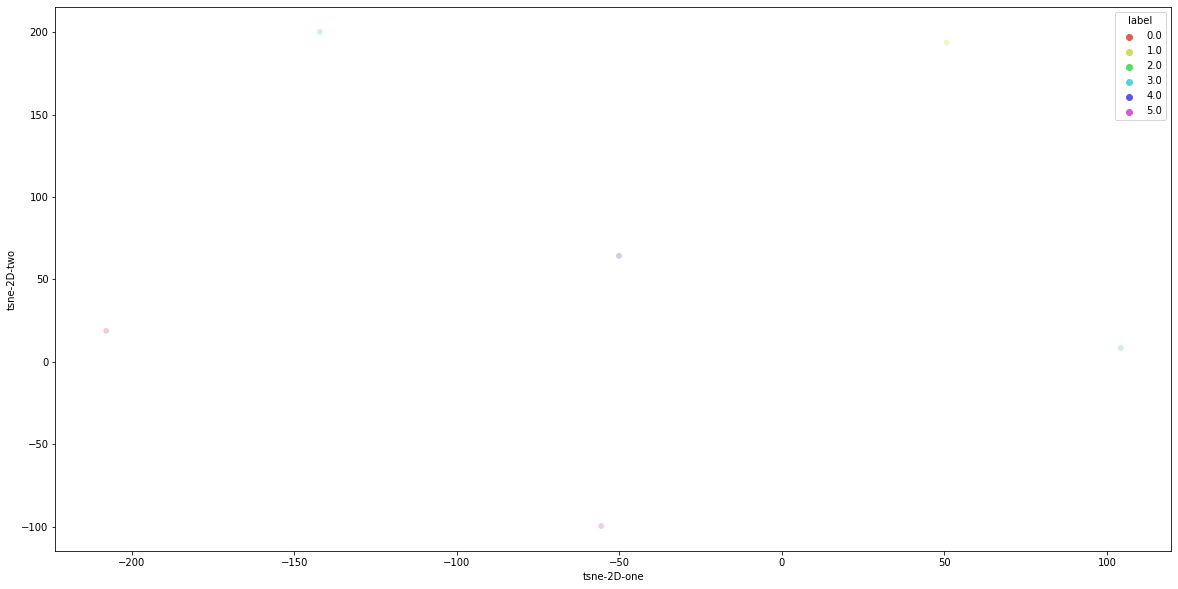

In [436]:
# tsne plot

data_subset = merged_df.drop(['label'],axis=1).values


tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=3000, init='pca', random_state=42)
tsne_results = tsne.fit_transform(data_subset)

merged_df['tsne-2D-one'] = tsne_results[:,0]
merged_df['tsne-2D-two'] = tsne_results[:,1]

plt.figure(figsize=(20,10))
sns.scatterplot(
    x="tsne-2D-one", 
    y="tsne-2D-two",
    hue = 'label',
    palette=sns.color_palette("hls", len(merged_df['label'].unique())),
    data=merged_df,
    legend="full",
    alpha=0.3
)

### BONUS QUESTION:

### Compare your trained model with other models trained using Fasttext

In [139]:
# fasttext
# Load pretrained FastText

import gensim.downloader as api

model_fastt = api.load("fasttext-wiki-news-subwords-300")

[==================================================] 100.0% 958.5/958.4MB downloaded


In [438]:
# checking for cosine similarities of 'computer'
model_fastt.most_similar("computer")

[('computers', 0.8472652435302734),
 ('non-computer', 0.8156518936157227),
 ('mini-computer', 0.8099768161773682),
 ('micro-computer', 0.7727647423744202),
 ('super-computer', 0.762492299079895),
 ('pre-computer', 0.7617331743240356),
 ('computor', 0.7485801577568054),
 ('computery', 0.7484371662139893),
 ('home-computer', 0.7476083040237427),
 ('computerless', 0.7416372299194336)]

In [437]:
# checking for cosine similarities of 'religion'
model_fastt.most_similar("religion")

[('non-religion', 0.8110731840133667),
 ('relgion', 0.8017660975456238),
 ('religion-', 0.7951573133468628),
 ('religions', 0.7949231266975403),
 ('irreligion', 0.7771246433258057),
 ('religionism', 0.7660502195358276),
 ('nonreligion', 0.7475364208221436),
 ('religionless', 0.7413093447685242),
 ('religiousness', 0.7410377264022827),
 ('quasi-religion', 0.7371302843093872)]

In [470]:
# checking for cosine similarities of 'game'
model_fastt.most_similar("game")

[('game-play', 0.8145623207092285),
 ('games', 0.8071571588516235),
 ('game-', 0.797581672668457),
 ('sub-game', 0.7643119692802429),
 ('game-making', 0.7637003064155579),
 ('midgame', 0.7632429599761963),
 ('subgame', 0.7536937594413757),
 ('gameplay', 0.749577522277832),
 ('meta-game', 0.7494497895240784),
 ('game-over', 0.7471526861190796)]

In [471]:
# checking for cosine similarities of 'america'
model_fastt.most_similar("america")

[('americas', 0.7932902574539185),
 ('america.', 0.7870339155197144),
 ('usa', 0.7484047412872314),
 ('europe', 0.7258652448654175),
 ('americans', 0.7255027294158936),
 ('american', 0.7204439640045166),
 ('mexico', 0.7188690900802612),
 ('england', 0.7098461985588074),
 ('amerika', 0.7033290266990662),
 ('britain', 0.6887056827545166)]

In [480]:
# Generate vectors from documents using Fasttext

vectorized_docs_fastt = vectorizer(tokenized_docs, WEmodel=model_fastt)
len(vectorized_docs_fastt)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  from ipykernel import kernelapp as app


18244

In [481]:
# Call the kmeans function definition to generate and analyze the clusters

clustering_fastt, cluster_labels_fastt = mbkmeans(vectorized_docs_fastt, k=6, print_silhouette_values=True)

For n_clusters = 6
Silhouette coefficient: 0.030
Inertia:1082.5105747874238
Silhouette values:
    Cluster 3: Size:63 | Avg:0.2323 | Min:-0.2331 | Max: 0.5115
    Cluster 2: Size:6624 | Avg:0.1002 | Min:0.0028 | Max: 0.1999
    Cluster 5: Size:3368 | Avg:0.0185 | Min:-0.1246 | Max: 0.1737
    Cluster 1: Size:764 | Avg:-0.0023 | Min:-0.1812 | Max: 0.2277
    Cluster 4: Size:4089 | Avg:-0.0041 | Min:-0.0821 | Max: 0.1212
    Cluster 0: Size:3336 | Avg:-0.0551 | Min:-0.1572 | Max: 0.0689


In [482]:
# new dataframe for predicted labels

df_clusters_fastt = pd.DataFrame({ "text": docs, "tokens": [" ".join(text) for text in tokenized_docs], "cluster_predicted_fastt": cluster_labels_fastt })
df_clusters_fastt

,text,tokens,cluster_predicted_fastt
0,sure bashers pen fan pretty confused lack kind...,sure bashers pen fan pretty confused lack kind...,2
1,brother market high performance video card sup...,brother market high performance video card sup...,4
2,finally said dream mediterranean new area grea...,finally said dream mediterranean new area grea...,2
3,think scsi card dma transfer disk scsi card dm...,think scsi card dma transfer disk scsi card dm...,5
4,old jasmine drive cannot use new system unders...,old jasmine drive cannot use new system unders...,4
...,...,...,...
18239,dn nyedacnsvaxuwecedu david nye dn neurology d...,dn nyedacnsvaxuwecedu david nye dn neurology d...,4
18240,isolated ground recepticles usually unusual co...,isolated ground recepticles usually unusual co...,4
18241,installed dx cpu clone motherboard tried mount...,installed dx cpu clone motherboard tried mount...,5
18242,wouldnt require hyper sphere space point speci...,wouldnt require hyper sphere space point speci...,0


In [444]:
df

,text,label,label_name,word_num_1,text_cleaned_after_punct_removal,text_cleaned_after_stopword_removal,tokens,lemmatized_text,final_text,word_num_2
0,\n\nI am sure some bashers of Pens fans are pr...,3,recreation,137,i am sure some bashers of pens fans are pretty...,sure bashers pens fans pretty confused lack ki...,"[sure, bashers, pens, fans, pretty, confused, ...","[sure, bashers, pen, fan, pretty, confused, la...",sure bashers pen fan pretty confused lack kind...,71
1,My brother is in the market for a high-perform...,0,computer,53,my brother is in the market for a high perform...,brother market high performance video card sup...,"[brother, market, high, performance, video, ca...","[brother, market, high, performance, video, ca...",brother market high performance video card sup...,34
2,\n\n\n\n\tFinally you said what you dream abou...,2,politics,241,finally you said what you dream about mediterr...,finally said dream mediterranean new area grea...,"[finally, said, dream, mediterranean, new, are...","[finally, said, dream, mediterranean, new, are...",finally said dream mediterranean new area grea...,120
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,0,computer,144,think its the scsi card doing the dma transfer...,think scsi card dma transfers disks scsi card ...,"[think, scsi, card, dma, transfers, disks, scs...","[think, scsi, card, dma, transfer, disk, scsi,...",think scsi card dma transfer disk scsi card dm...,71
4,1) I have an old Jasmine drive which I cann...,0,computer,125,i have an old jasmine drive which i cannot us...,old jasmine drive cannot use new system unders...,"[old, jasmine, drive, cannot, use, new, system...","[old, jasmine, drive, cannot, use, new, system...",old jasmine drive cannot use new system unders...,56
...,...,...,...,...,...,...,...,...,...,...
18841,DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...,5,science,300,dn from nyedacnsvaxuwecedu david nye dn a neur...,dn nyedacnsvaxuwecedu david nye dn neurology d...,"[dn, nyedacnsvaxuwecedu, david, nye, dn, neuro...","[dn, nyedacnsvaxuwecedu, david, nye, dn, neuro...",dn nyedacnsvaxuwecedu david nye dn neurology d...,166
18842,\nNot in isolated ground recepticles (usually ...,5,science,28,not in isolated ground recepticles usually an ...,isolated ground recepticles usually unusual co...,"[isolated, ground, recepticles, usually, unusu...","[isolated, ground, recepticles, usually, unusu...",isolated ground recepticles usually unusual co...,18
18843,I just installed a DX2-66 CPU in a clone mothe...,0,computer,113,i just installed a dx cpu in a clone motherboa...,installed dx cpu clone motherboard tried mount...,"[installed, dx, cpu, clone, motherboard, tried...","[installed, dx, cpu, clone, motherboard, tried...",installed dx cpu clone motherboard tried mount...,50
18844,\nWouldn't this require a hyper-sphere. In 3-...,0,computer,56,wouldnt this require a hyper sphere in space p...,wouldnt require hyper sphere space points spec...,"[wouldnt, require, hyper, sphere, space, point...","[wouldnt, require, hyper, sphere, space, point...",wouldnt require hyper sphere space point speci...,27


## By comparing the label columns of the orginal and predicted dataframes, we found that the predictions doesnot gets better with Fasttext

In [483]:
# top 10 terms/tokens per cluster (w.r.t. words frequencies)

for i in range(6):
    tokens_per_cluster_fastt = ""
    freq_token_fastt = Counter(" ".join(df_clusters_fastt.query(f"cluster_predicted_fastt == {i}")["tokens"]).split()).most_common(10)

    for t in freq_token_fastt:
        tokens_per_cluster_fastt += f"{t[0]}({str(t[1])}) "
    print(f"Cluster {i}: {tokens_per_cluster_fastt}")

Cluster 0: dont(1553) would(1542) know(1413) get(1381) like(1243) im(1132) one(1121) think(880) want(740) say(684) 
Cluster 1: x(2212) c(482) v(456) e(333) entry(327) r(315) k(266) b(248) la(247) n(236) 
Cluster 2: one(5536) would(5050) people(4015) dont(2933) like(2926) god(2892) think(2842) time(2785) know(2730) get(2491) 
Cluster 3: x(4211) q(3656) maxaxaxaxaxaxaxaxaxaxaxaxaxaxax(3317) f(2958) u(2640) w(2039) p(1686) b(1489) e(1480) v(1344) 
Cluster 4: one(2606) would(2150) use(1812) also(1736) file(1734) system(1721) time(1540) image(1501) new(1464) people(1347) 
Cluster 5: x(2637) one(1454) window(1427) system(1305) use(1295) would(1271) file(1234) get(1229) also(1200) know(1118) 


In [484]:
# find the most representative documents (w.r.t. clusters centroids)

test_cluster = 2
most_representative_docs_fastt = np.argsort(
    np.linalg.norm(vectorized_docs_fastt - clustering_fastt.cluster_centers_[test_cluster], axis=1)
)
for d in most_representative_docs_fastt[:10]:
    print(docs[d])
    print("-------------")

amazing everyone automatically blame one side one thing sure koresh chance defend statement lacking fact court sponsored verification made agent participated situation killed dont know murdered also dont know branch davidians set fire suicidede sick batf fbi spokepeople make comment advance forensic pathology stephen thank god speed yah bingo one notice peaceful attempt serve warrant b six month develop scene six day end c ah god child least adult plus beginning batf agent dead anyone asked question seen entire video sequence taken opening round seem recall missing several key part first five minute day one shooting part come b happened fed video unit mean carry helmet cam wonder camera crew live transmission video present uninterrupted record realize unit carry ittle bitty mm backup hold minute per unit twounits professional handhelds tape turnover gap b view seen premature point finger either direction well point stephen yes hard toremain human full pressure hazard game playing life 

In [485]:
# random sample of documents for a given cluster

for i,t in enumerate(df_clusters_fastt.query(f"cluster_predicted_fastt == {test_cluster}").sample(10).iterrows()):
    print(t[1]["text"])
    print("-------------")

saw previous request rule instruction usenet playoff pool havent seen responce anybody info post away could mail thanks advance
-------------
would make bit suspect mr ramseys qualification self styled expert fact read anybody using virtual memory regularly kind wonder yes one sometimes get away running newer rom correct size obviously older machine one prepared problem running software check machine type rather rom trap availability draw incorrect conclusion special casing especially timing dependent driver related stuff particular case see reason go trouble rom swapping apple bit enabler problem mode work fine sure buy used iici motherboard call pre owned electronics shreve part dealer see back computer shopper one mac trade phone number ask price iici rom everything price happen find somebody salvaged iici dead motherboard might get decent price probably market used mother board well might sell rom anyway ask quote try offering le pre owned shreve known dicker ad various trade magaz